# Examine The Blocking and Matcher Results from experiments

In [3]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score,roc_auc_score, auc
from evaluation_functions import *


# TODO: work out how to genearted matching results when using LSH as a matcher
# TODO validate metrics like end to end recall
result = pickle.load(open("../results/magellan_Jul_20_2017.p","rb"))
blocking_results = blocking_results_with_meta(result)
matcher_results = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df)


result = pickle.load(open("../results/deep_matcher_Jul_22_2347.p","rb"))
matcher_results_deep = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True)

result = pickle.load(open("../results/deep_matcher_hybrid_Jul_23_1630.p","rb"))
matcher_results_deep_hybrid = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True)

matcher_results = pd.concat([matcher_results,matcher_results_deep,matcher_results_deep_hybrid])
# Mergin results
all_results = pd.merge(matcher_results, blocking_results,left_index = True, right_index = True, suffixes = ("_m","_b"))

all_results["best_case_overall_recall"] = all_results.test_recall_b * all_results.test_recall_m.apply(np.max)



# Evaluate Blocking Performance

## Pruning Power

In [10]:
blocking_results.groupby(["blocking_algo"]).apply(np.mean)

,train_prune,valid_prune,test_prune,train_recall,valid_recall,test_recall,post_train_size,post_valid_size,post_test_size
blocking_algo,,,,,,,,,
lsh,0.964704,0.962630,0.953357,0.786678,0.542056,0.873932,2693.0,291.0,333.0
sequential,0.930031,0.932838,0.914372,0.374560,0.273754,0.412749,2693.0,291.0,333.0


## Recall

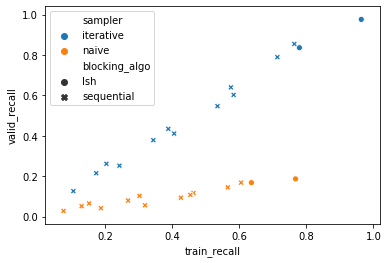

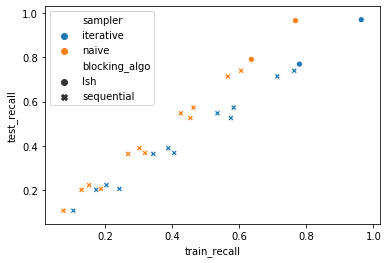

train_prune  valid_prune  test_prune  train_recall  \
sampler   blocking_algo                                                       
iterative lsh               0.966090     0.958297    0.953719      0.871479   
          sequential        0.931316     0.931753    0.914372      0.419699   
naive     lsh               0.963319     0.966962    0.952996      0.701878   
          sequential        0.928747     0.933924    0.914372      0.329421   

                         valid_recall  test_recall  post_train_size  \
sampler   blocking_algo                                               
iterative lsh                0.906542     0.869658           2693.0   
          sequential         0.459502     0.412749           2693.0   
naive     lsh                0.177570     0.878205           2693.0   
          sequential         0.088006     0.412749           2693.0   

                         post_valid_size  post_test_size  
sampler   blocking_algo                                   
iterative lsh                      291.0           333.0  
          sequential               291.0           333.0  
naive     lsh                      291.0           333.0  
          sequential               291.0           333.0

In [8]:
sns.scatterplot(x = blocking_results.train_recall, y = blocking_results.valid_recall, style = blocking_results.blocking_algo, hue = blocking_results.sampler)
plt.show()

sns.scatterplot(x = blocking_results.train_recall, y = blocking_results.test_recall, style = blocking_results.blocking_algo, hue = blocking_results.sampler)
plt.show()

blocking_results.groupby(["sampler","blocking_algo"]).apply(np.mean)

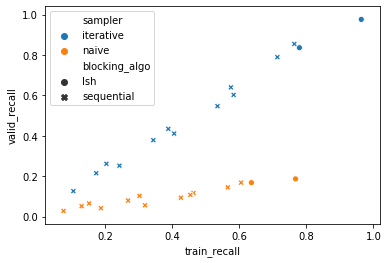

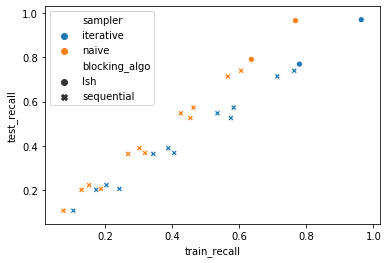

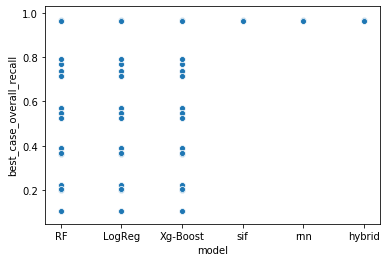

In [4]:
# Visualise some results




matcher_results.groupby(["sampler","blocking_algo"]).apply(np.mean)
matcher_results.groupby(["model","sampler","blocking_algo"]).apply(np.mean)
#NB
matcher_results.query("blocking_algo == 'lsh'").groupby(["model","sampler"]).apply(np.mean)



sns.scatterplot(x = all_results.model, y = all_results.best_case_overall_recall)

#print(all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall"]].sort_values("best_case_overall_recall", ascending = False))


# Plot top 3 and bottom 3 precision recall curves
top_3 = all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall","test_precision","test_recall_m"]].nlargest(3,"best_case_overall_recall")
bottom_3 = all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall","test_precision","test_recall_m"]].nsmallest(3,"best_case_overall_recall")

#Note the use of explode
plotting_data = pd.concat([top_3,bottom_3])
plotting_data["id"] = np.arange(plotting_data.shape[0])
#plotting_data = pd.melt(plotting_data, id_vars = ["id","sampler_m","blocking_algo_m","model"], value_vars=["test_precision","test_recall_m"]).explode("value")
# plotting_data.reset_index(inplace = True)
# plotting_data.value = plotting_data.value.astype(float)


#tt = plotting_data.pivot_table(index=[plotting_data.index,plotting_data.id],columns='variable',values='value',fill_value=0)

#sns.lineplot(data =tt, x = "test_precision", y = "test_recall_m", hue = np.array(tt.index.get_level_values(1)))







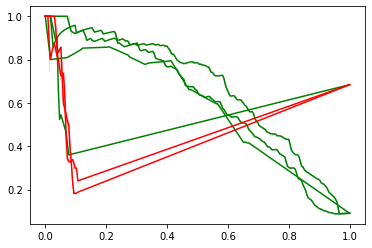

In [7]:
for id_val in np.arange(plotting_data.shape[0]):
    if (id_val <=plotting_data.shape[0]/2):
        colour = "green"
    else:
        colour = "red"
    ax = sns.lineplot(y = "test_precision" , x = "test_recall_m", data = plotting_data.iloc[id_val,:], color = colour)
plt.show()


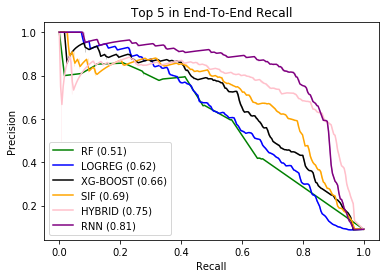

In [6]:
# Plot only top 6
top_6 = all_results[["sampler_m","blocking_algo_m","model","best_case_overall_recall","test_precision","test_recall_m","test_average_precision"]].nlargest(6,"best_case_overall_recall")
colours = {"RF":"green","LogReg":"blue","Xg-Boost":"black","sif":"orange","rnn":"purple","hybrid":"pink"}
top_6 = top_6.sort_values("test_average_precision")
top_6["id"] = np.arange(top_6.shape[0])

for id_val in top_6.id:

    model_name = top_6.ix[id_val,"model"]
    #print(model_name)
    avg_precision  = round(top_6.iloc[id_val,:].test_average_precision,2)
    label_val = f"{model_name.upper()} ({avg_precision})"

    ax = sns.lineplot(y = "test_precision" , x = "test_recall_m", data = top_6.iloc[id_val,:], color = colours[model_name], label = label_val)
ax.set(ylabel="Precision", xlabel = "Recall", title = "Top 5 in End-To-End Recall")
plt.show()